In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import itertools
from collections import defaultdict
from IPython.display import clear_output

# Classes

In [1]:
class Grid:
    def __init__(self, minute_part, hours = 24):
        self.hours = hours
        self.minute_part = minute_part
        self.Grid = pd.DataFrame(None, columns= [(y, x) for y in range(hours) for x in range(minute_part)], dtype = bool)
        
    def insert(self, idx, times: list):
        self.Grid.loc[idx] = [ x in set(times) for x in self.Grid.columns]
        
    def delete(self, idx):
        if idx in self.Grid.index:
            self.Grid.drop(index=idx, inplace= True)
        else:
            print("Not in index")
    
    def change(self, idx, times: list, value):
        self.Grid.loc[idx] = [ value if x in set(times) else y for x,y in zip(self.Grid.columns, self.Grid.loc[idx])]
    
    def isAvailable(self, idx, times: list):
        if idx not in self.Grid.index:
            print("Not an appropriate index")
            return False
        
        pos = self.Grid.index.get_loc(idx)
        return self.Grid.iloc[pos, times[0]*self.minute_part + times[1]]
    
    def getTotal(self, times):
        return self.Grid[times].sum()
    def getTotalbyidx(self, idx):
        return self.Grid.loc[idx].sum()
    
    def getAvailable(self, time):
        return self.Grid.loc[self.Grid[time] == True][time]
    
    def getEntropybyColumn(self):
        if self.Grid.shape[0] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        EntropybyRow = np.zeros(shape=(self.Grid.shape[0],1))
        
        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            EntropybyRow[count] = entropy([prob, 1-prob])
        
        #print("E Done")
        return EntropybyRow
    
    def getEntropybyRow(self):
        if self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        EntropybyCol = np.zeros(shape=(1,self.Grid.shape[1]))
        
        
        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            EntropybyCol[0,count] = entropy([prob, 1-prob])
        
        #print("E Done")
        return EntropybyCol
    def getJointEntropy(self):
        
        if self.Grid.shape[0] == 0 or self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        ProbByRow = np.zeros(shape=(self.Grid.shape[0],1))
        ProbByCol = np.zeros(shape=(1,self.Grid.shape[1]))
        
        for count, person in enumerate(self.Grid.index): # likelihood of a person being available
            #prob = self.getTotalbyidx(person)/self.Grid.shape[1]
            prob = 1/self.getTotalbyidx(person)
            ProbByRow[count] = prob

        for count, time in enumerate(self.Grid): # likelihood of an available space
            #prob = self.getTotal(time)/self.Grid.shape[0]
            prob = 1/self.getTotal(time)
            ProbByCol[0,count] = prob
        
        
        probTable = ProbByRow * ProbByCol
        
        for row in range(probTable.shape[0]):
            for col in range(probTable.shape[1]):
                probTable[row, col] = entropy([probTable[row,col], 1-probTable[row,col]])
                
        return probTable
    def getMutualInformation(self):
        #print(probTable)
        #print("Done")
        return self.getEntropybyColumn() + self.getEntropybyRow() - self.getJointEntropy()
        
    def getNextAvailable(self, time):
        ser = self.getAvailable(time)
        return ser.sort_index(key = lambda x: [self.getTotalbyidx(y) for y in x])
    def print(self):
        print(self.Grid)
    

In [3]:
class Person:
    newid = itertools.count()
    def __init__(self, id = None, availability= set()):
        if id is None:
            self.id = next(Person.newid)
        else:
            self.id = id
            
        self.availability = set()
        
    def reset():
        Person.newid = itertools.count()
        
            

In [4]:
def getBestSpot(people, grid):
    
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    #print(EntTable.shape)
    
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    ct = 1
    #print(best)
    while len(set(best.values())) != len(best):
        last = {}
        for count, k in enumerate(best):
            
            if best[k] not in last:
                last[best[k]] = k
                #print(last)
            else:
                #compare with last instance of the entropy table index
                #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                test_last = tableInd[last[best[k]], idxCt[last[best[k]]]+1 ]
                test_new = tableInd[count, idxCt[k]+1]
                
                if EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                    #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                    if not np.isinf(EntTable[ last[best[k]], test_last]):
                        idxCt[ last[best[k]] ] += 1
                        last[best[k]] = k
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                    #print("prior min idxCt: ", idxCt[last[best[k]]])
                elif EntTable[ last[best[k]] , best[ last[best[k]] ] ] < EntTable[count, best[k]]:
                    if not np.isinf(EntTable[count, test_new]):
                        idxCt[k] += 1
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                            last[best[k]] = k
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                    #print("current min idxCt: ", idxCt[k])
                else: # local minimum entropy equals current key entropy
                    #check if both can decriment then check if current less than 
                    if EntTable[count, test_new] < EntTable[last[best[k]], test_last]:
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                            last[best[k]] = k
                        else:
                        #print("Testing Other... ")
                            if not np.isinf(EntTable[count, test_new]):
                                idxCt[k] += 1
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    else:
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            #print("Testing Other... ")
                            if not np.isinf(EntTable[ last[best[k]], test_last]):
                                idxCt[ last[best[k]] ] += 1
                                last[best[k]] = k
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    
                #end loop
            #update to current instance
            best[k] = tableInd[count, idxCt[k]]
            ct += 1
            print("Alg1:, ", len(set(best.values())), "/", len(best))
            if ct % 2 == 0:
                clear_output(wait=True)
                
            if ct == EntTable.size * 100:
                return None, tableInd, idxCt, EntTable
        
    return best, tableInd, idxCt, EntTable



In [5]:
def getBestSpot2(people, grid):
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    
    #return a list of indices representing Entropy in ascending order
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    
    #for each key set a counter to the beginning of the list
    ct = 1
    #condition to ensure each one is unique
    while len(set(best.values())) != len(best):
        conflict = {}
        #find conflicts
        for k in best:
            if best[k] not in conflict:
                conflict[best[k]] = []
            
            conflict[best[k]].append(k)
        #resolve conflicts
        
        for k in conflict:
            minCidx = 0
            #for each step compare to previous minimum value in Information Table (EntTable) and
            # if no longer the min value or if greater - incriment counter on respective keys
            for count, val in enumerate(conflict[k]):
                if val == conflict[k][minCidx]:
                    #print("Next")
                    continue

                test_last = tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx]]+1 ]
                test_new = tableInd[val, idxCt[val]+1]
                
                if EntTable[val, k] < EntTable[conflict[k][minCidx], k]:
                    #print("less")
                    if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                        idxCt[conflict[k][minCidx]] += 1
                        minCidx = count
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                
                elif EntTable[val, k] > EntTable[conflict[k][minCidx], k]:
                    #print("more")
                    if not np.isinf(EntTable[val, test_new]):
                        idxCt[conflict[k][count]] += 1
                    else:
                        if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                            idxCt[conflict[k][minCidx]] += 1
                            minCidx = count
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                #when equal resolve by next least value
                else:
                    #break ties on lookahead
                    if EntTable[val, test_new] < EntTable[conflict[k][minCidx], test_last]:
                        if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                            idxCt[conflict[k][minCidx]] += 1
                            minCidx = count
                        else:
                            if not np.isinf(EntTable[val, test_new]):
                                idxCt[conflict[k][count]] += 1
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                                idxCt[conflict[k][minCidx]] += 1
                                minCidx = count
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable


            #update table
            for k in best:
                best[k] = tableInd[k, idxCt[k]]
                
            print("Alg2:, ", len(set(best.values())), "/", len(best))
            ct+= 1
            if ct % 2 == 0:
                clear_output(wait=True)
            if ct == EntTable.size * 100:
                return None, tableInd, idxCt, EntTable
        
    return best, tableInd, idxCt, EntTable

# Test Classes

In [6]:
HOUR_PARTITIONS = 48
HOURS = 24
Num_People = 26
def fillGrid(perc):
    return math.floor(perc* (HOUR_PARTITIONS*HOURS))
people = [Person() for x in range(Num_People)]

In [7]:
test = Grid(4, hours = 4)
#test.print()
test.insert(20, [(0,0),(0,3),(2,2)])

test.insert(0, [(0,3)])
test.insert(3, [(0,0)])
test.change(3, [(1,0)], True)

print("Test is Available: ", test.isAvailable(3, (1,1)), "\n" )
display(test.getAvailable((0,0)) )
print("\nTest Total by Row: ", test.getTotalbyidx(20))
print("Test Total by Column: ", test.getTotal((0,0)), "\n" )

display(test.getNextAvailable((0,0)) )
display(test.Grid)
print(test.Grid.shape)

Test is Available:  False 



20    True
3     True
Name: (0, 0), dtype: bool


Test Total by Row:  3
Test Total by Column:  2 



3     True
20    True
Name: (0, 0), dtype: bool

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
20,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


(3, 16)


In [8]:
test.delete(4)
test.getTotal((2,2))

Not in index


1

In [9]:
test.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (1, 0)  (1, 1)  (1, 2)  (1, 3)  (2, 0)  \
20    True   False   False    True   False   False   False   False   False   
0    False   False   False    True   False   False   False   False   False   
3     True   False   False   False    True   False   False   False   False   

    (2, 1)  (2, 2)  (2, 3)  (3, 0)  (3, 1)  (3, 2)  (3, 3)  
20   False    True   False   False   False   False   False  
0    False   False   False   False   False   False   False  
3    False   False   False   False   False   False   False  


In [10]:
test.isAvailable(4, (2,2))

Not an appropriate index


False

In [11]:
test.isAvailable(3, (1,0))

True

In [12]:
schedule = Grid(HOUR_PARTITIONS)

def createTupList(Hours, Minutes, size):
    #s = set()
    #while len(s) != size:
    #    s.add(tuple(np.random.randint(maxval, size = 2, dtype = np.uint64)))
    #print("\n", list(s))
    #print("Length of list: ", len(s))
    #return list(s)
    return [(np.random.randint(Hours, dtype=np.uint64), np.random.randint(Minutes, dtype=np.uint64)) for x in range(size)]

for person in people:
    r_size = np.random.randint(schedule.Grid.shape[1], dtype = np.uint64)
    #print(person.id)
    schedule.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
schedule.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  \
0     True    True   False   False    True    True    True   False   False   
1     True   False   False   False   False    True   False   False   False   
2    False   False   False   False   False   False   False   False   False   
3    False   False   False   False   False   False   False   False    True   
4     True   False   False   False    True   False   False   False   False   
5    False   False   False   False   False   False   False   False   False   
6    False   False   False    True   False    True    True    True   False   
7    False   False    True   False   False    True    True   False   False   
8    False   False   False   False   False    True   False   False    True   
9    False   False   False   False    True    True   False    True   False   
10    True    True   False   False   False   False   False    True    True   
11   False   False    True    True   False    True   False   Fal

# Calculate the loss 
- Entropy of the person plus entropy of the space, H(P(x)/m*n) + H(M(x)/X)
    - minimize such that the total entropy of remaining spaces is the most possible
- where E(P(x)/m*n) is the entropy for person,P, and P(x) is total available
- where E(M(x)/X) is the entropy of available People, M(x), against total People, X
# Operations:
How to keep track of positions
How to deal with failure end state (is it reversible?)
How to represent success state (used dictionary)
Best way to find next position (sorted numpy array along index)

# Failure States:
When X > m*n
When dictionary reaches inf.
# Success state:
When all values in Dictonary are unique

In [13]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available in " + str(schedule.getTotalbyidx(person.id)) + " Spots\t\t"
    if count % 2 == 0:
        print(out)
        out = ""

if out != "":
    print(out)

0 Person available in 649 Spots		1 Person available in 202 Spots		
2 Person available in 167 Spots		3 Person available in 255 Spots		
4 Person available in 228 Spots		5 Person available in 133 Spots		
6 Person available in 300 Spots		7 Person available in 388 Spots		
8 Person available in 591 Spots		9 Person available in 164 Spots		
10 Person available in 678 Spots		11 Person available in 484 Spots		
12 Person available in 166 Spots		13 Person available in 396 Spots		
14 Person available in 83 Spots		15 Person available in 340 Spots		
16 Person available in 360 Spots		17 Person available in 395 Spots		
18 Person available in 618 Spots		19 Person available in 523 Spots		
20 Person available in 381 Spots		21 Person available in 687 Spots		
22 Person available in 433 Spots		23 Person available in 43 Spots		
24 Person available in 365 Spots		25 Person available in 257 Spots		


In [14]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available {:.4%} of times\t".format(schedule.getTotalbyidx(person.id)/schedule.Grid.shape[1])
    if count % 2 == 0:
        print(out)
        out = ""
if out != "":
    print(out)

0 Person available 56.3368% of times	1 Person available 17.5347% of times	
2 Person available 14.4965% of times	3 Person available 22.1354% of times	
4 Person available 19.7917% of times	5 Person available 11.5451% of times	
6 Person available 26.0417% of times	7 Person available 33.6806% of times	
8 Person available 51.3021% of times	9 Person available 14.2361% of times	
10 Person available 58.8542% of times	11 Person available 42.0139% of times	
12 Person available 14.4097% of times	13 Person available 34.3750% of times	
14 Person available 7.2049% of times	15 Person available 29.5139% of times	
16 Person available 31.2500% of times	17 Person available 34.2882% of times	
18 Person available 53.6458% of times	19 Person available 45.3993% of times	
20 Person available 33.0729% of times	21 Person available 59.6354% of times	
22 Person available 37.5868% of times	23 Person available 3.7326% of times	
24 Person available 31.6840% of times	25 Person available 22.3090% of times	


In [15]:
disp = pd.DataFrame(schedule.getJointEntropy(), columns= schedule.Grid.columns)

In [16]:
display(disp)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,1.267587,1.225299,inf,inf,1.174646,1.366360,1.302336,inf,inf,inf,...,1.267587,inf,1.330128,1.375280,inf,1.174646,1.330128,1.366360,1.375280,inf
1,1.046757,inf,inf,inf,inf,1.145530,inf,inf,inf,inf,...,inf,inf,inf,1.154450,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.996368,inf,inf,1.104061,inf,inf,inf,1.095141,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,1.209882,inf,...,inf,inf,1.173650,inf,inf,inf,1.173650,inf,inf,inf
4,1.079993,inf,inf,inf,0.987053,inf,inf,inf,inf,inf,...,1.079993,inf,inf,1.187686,inf,inf,inf,inf,1.187686,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.047949,inf
6,inf,inf,inf,1.113696,inf,1.254758,1.190734,1.155985,inf,inf,...,inf,1.113696,1.218525,inf,1.190734,inf,1.218525,inf,1.263678,inf
7,inf,inf,1.179098,inf,inf,1.320160,1.256136,inf,inf,1.221386,...,1.221386,inf,1.283927,inf,inf,inf,inf,1.320160,1.329080,inf
8,inf,inf,inf,inf,inf,1.374074,inf,inf,1.374074,inf,...,inf,inf,1.337841,inf,1.310050,inf,1.337841,inf,inf,inf
9,inf,inf,inf,inf,0.898778,1.090492,inf,0.991719,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.099412,inf


In [17]:
pd.DataFrame(schedule.getMutualInformation(), columns= schedule.Grid.columns)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,1.265513,1.222919,inf,inf,1.171847,1.364977,1.300496,inf,inf,inf,...,1.265513,inf,1.328472,1.374001,inf,1.171847,1.328472,1.364977,1.374001,inf
1,1.040919,inf,inf,inf,inf,1.141612,inf,inf,inf,inf,...,inf,inf,inf,1.150823,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.989470,inf,inf,1.099768,inf,inf,inf,1.090506,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,1.206695,inf,...,inf,inf,1.169842,inf,inf,inf,1.169842,inf,inf,inf
4,1.074745,inf,inf,inf,0.980001,inf,inf,inf,inf,inf,...,1.074745,inf,inf,1.184428,inf,inf,inf,inf,1.184428,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.042701,inf
6,inf,inf,inf,1.108977,inf,1.252000,1.187074,1.151866,inf,inf,...,inf,1.108977,1.215229,inf,1.187074,inf,1.215229,inf,1.261126,inf
7,inf,inf,1.175338,inf,inf,1.317967,1.253223,inf,inf,1.218107,...,1.218107,inf,1.281304,inf,inf,inf,inf,1.317967,1.327051,inf
8,inf,inf,inf,inf,inf,1.372569,inf,inf,1.372569,inf,...,inf,inf,1.336040,inf,1.308049,inf,1.336040,inf,inf,inf
9,inf,inf,inf,inf,0.889378,1.085782,inf,0.984711,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.095050,inf


In [18]:
points = [] # [ [[],[]], ...]
for idx, row in disp.iterrows():
    data = []
    col = []
    for count, (pt, column) in enumerate(zip(row,disp.columns)):
        if schedule.isAvailable(idx, column):
            col.append(count)
            data.append(pt)
    points.append([col, data])

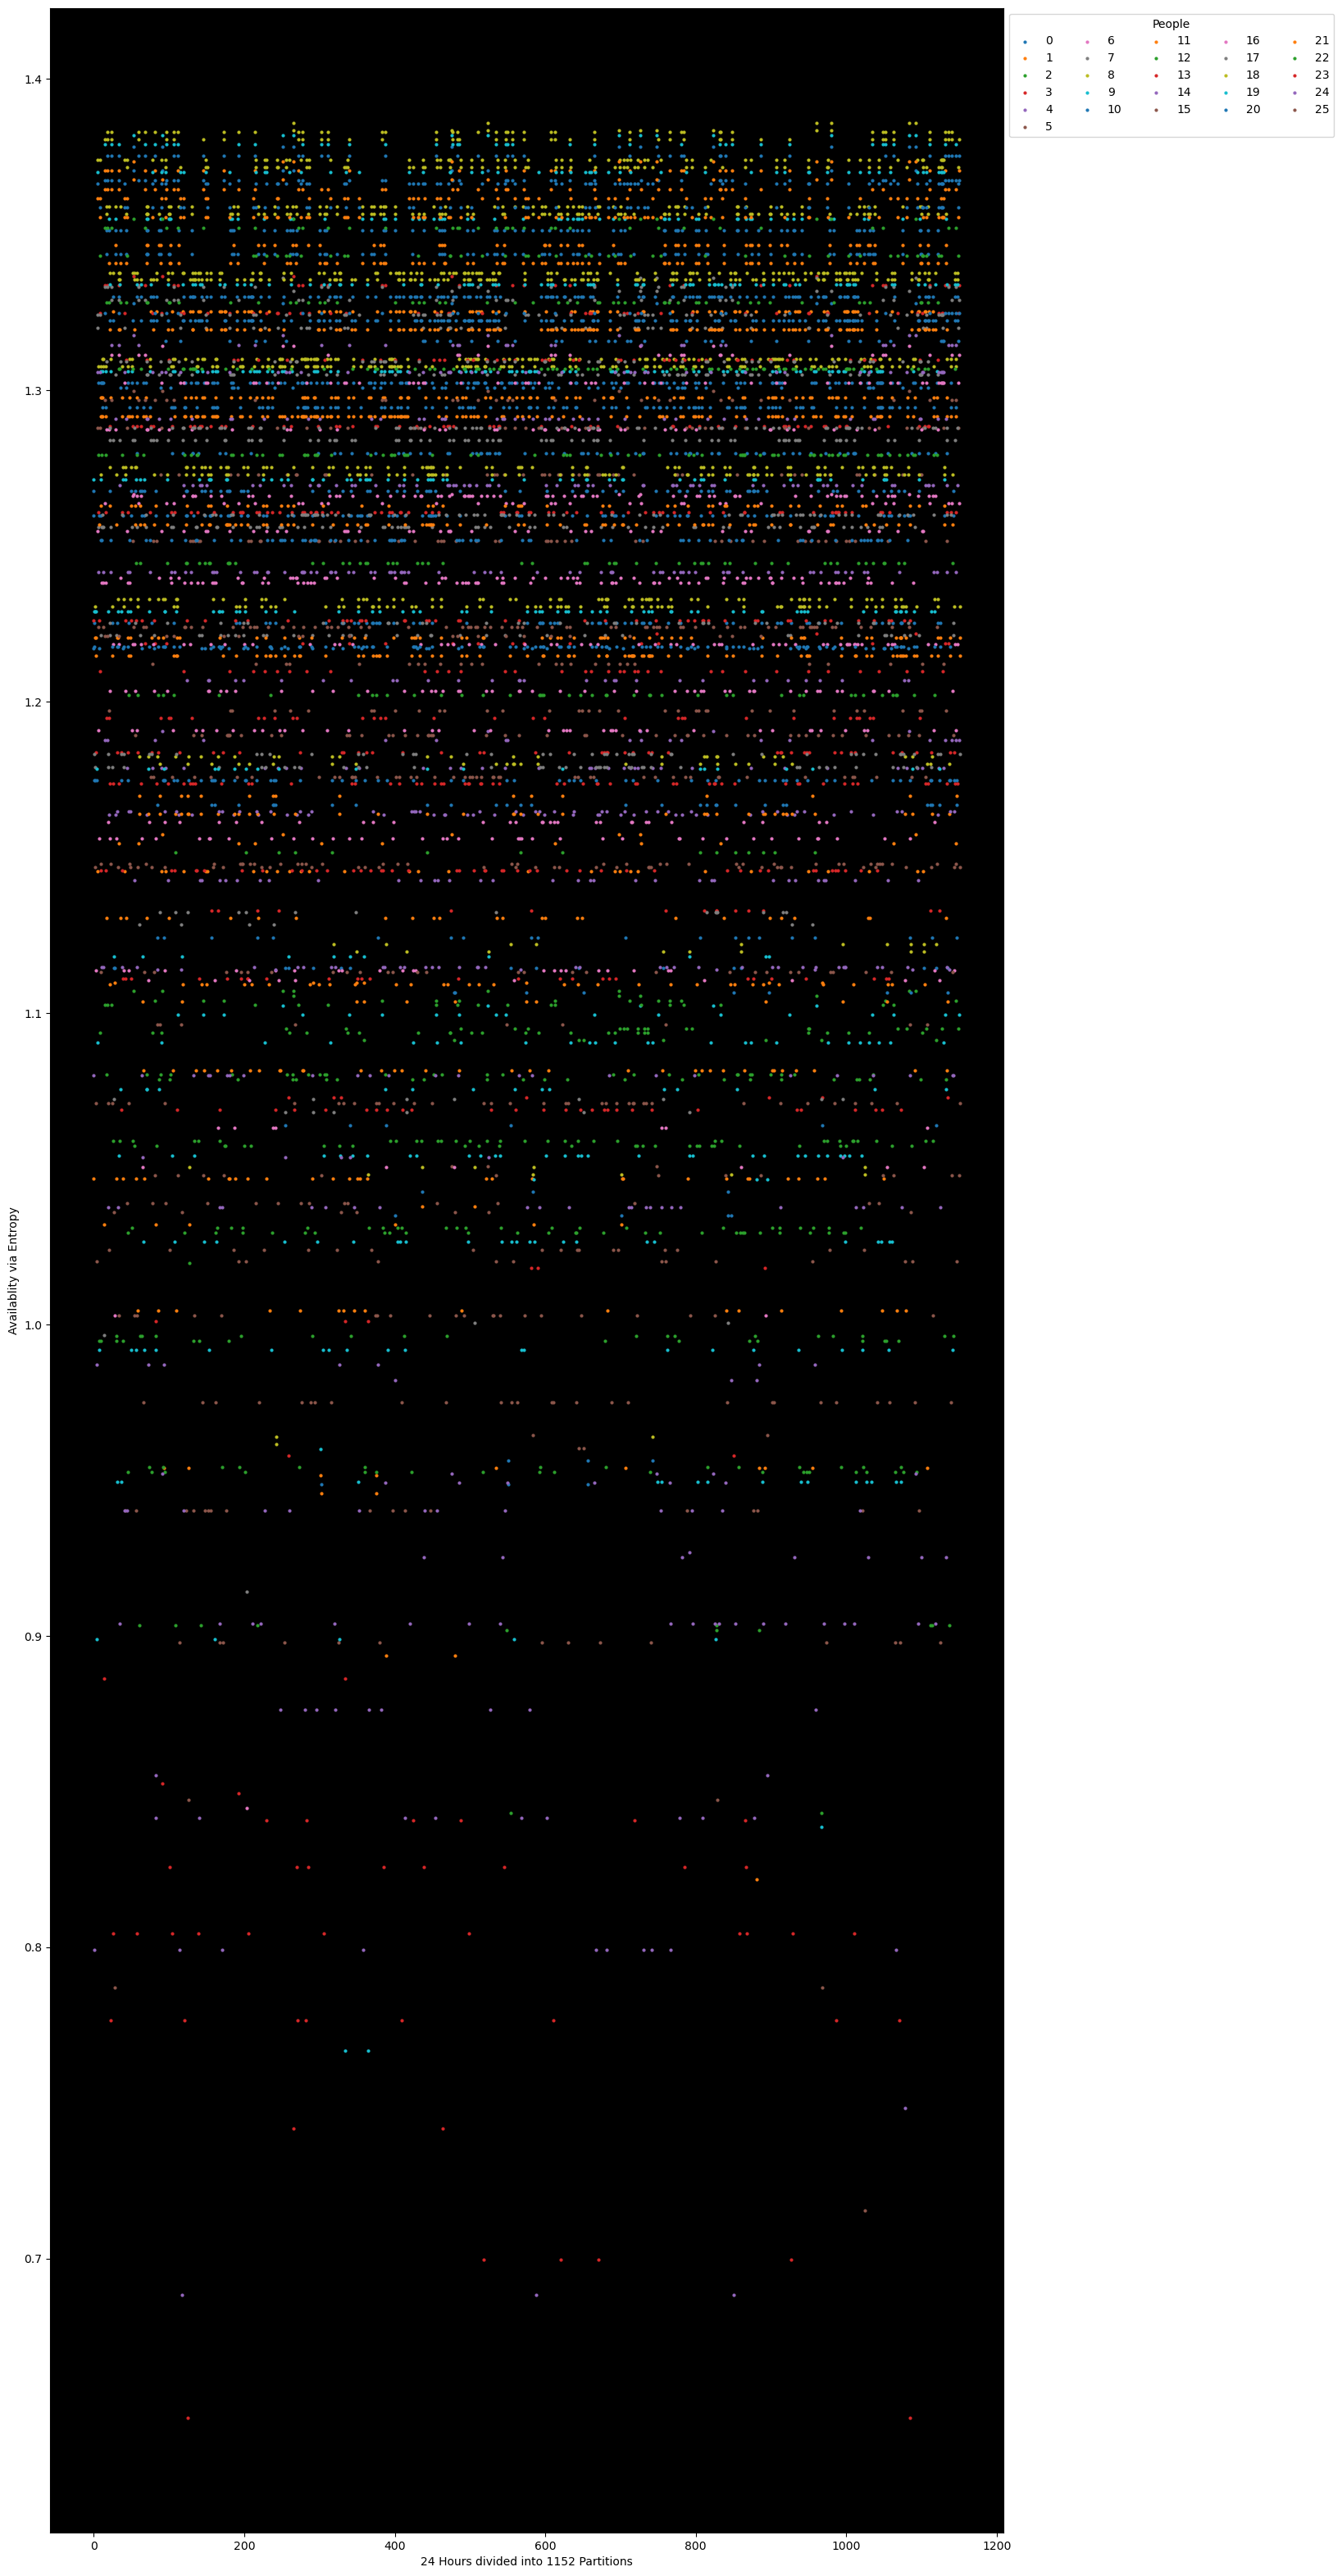

In [19]:
fig , ax = plt.subplots()

for pts, idx in zip(points, disp.index):
    ax.scatter(pts[0], pts[1], s = 4, label = idx)
    
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)

ax.set_facecolor('black')
ax.set_xlabel("{Hours:} Hours divided into {Min_part} Partitions".format(Hours=HOURS, Min_part = HOURS*HOUR_PARTITIONS))
ax.set_ylabel("Availablity via Entropy")
fig.set_figwidth(15)
fig.set_figheight(40)

#plot = plt.scatter(np.arange(len(disp.columns))+ np.zeros(shape=(len(disp.index), 1), dtype = int), disp.to_numpy())
plt.show()

In [22]:
best, idxes, idxCts, Entropy = getBestSpot(people, schedule)

best2, idxes2, idxCts2, Entropy2 = getBestSpot2(people, schedule)

Alg2:,  26 / 26
Alg2:,  26 / 26


In [23]:
output = ""
summ = 0
for count, spot in enumerate(best):
    output += str(spot) + ": " + str(best[spot]) + ", Entropy: {:4}".format(Entropy[count,best[spot]]) + "\t\t"
    summ +=  Entropy[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total capacity:", summ)

0: 742, Entropy: 0.9499909862397762		1: 881, Entropy: 0.8096703722715282		
2: 967, Entropy: 0.8319656942089908		3: 334, Entropy: 0.8762577981463966		
4: 83, Entropy: 0.8441231540460444		5: 1025, Entropy: 0.6978772568965936		
6: 203, Entropy: 0.8323548329575574		7: 14, Entropy: 0.989597308194875		
8: 506, Entropy: 1.045652281470865		9: 365, Entropy: 0.7522247155674187		
10: 551, Entropy: 0.942518315937474		11: 376, Entropy: 0.9433911267291751		
12: 884, Entropy: 0.8925816751481728		13: 575, Entropy: 1.0675321299692488		
14: 117, Entropy: 0.6677362887051497		15: 895, Entropy: 0.956544579625327		
16: 1054, Entropy: 1.0446649165622888		17: 843, Entropy: 0.993739635873135		
18: 243, Entropy: 0.9551068155877867		19: 301, Entropy: 0.952494747937572		
20: 341, Entropy: 1.0585517713900445		21: 302, Entropy: 0.9396653768625444		
22: 127, Entropy: 1.0133435593527127		23: 1084, Entropy: 0.6192839881134864		
24: 847, Entropy: 0.9747877689531268		25: 651, Entropy: 0.9523957523745213		
Total capacity

In [24]:
output = ""
summ = 0
for count, spot in enumerate(best2):
    output += str(spot) + ": " + str(best2[spot]) + ", Entropy: {:4}".format(Entropy2[count,best2[spot]]) + "\t\t"
    summ +=  Entropy2[count,best2[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total Capacity: ", summ)

0: 742, Entropy: 0.9499909862397762		1: 881, Entropy: 0.8096703722715282		
2: 967, Entropy: 0.8319656942089908		3: 334, Entropy: 0.8762577981463966		
4: 83, Entropy: 0.8441231540460444		5: 1025, Entropy: 0.6978772568965936		
6: 203, Entropy: 0.8323548329575574		7: 14, Entropy: 0.989597308194875		
8: 506, Entropy: 1.045652281470865		9: 365, Entropy: 0.7522247155674187		
10: 551, Entropy: 0.942518315937474		11: 376, Entropy: 0.9433911267291751		
12: 884, Entropy: 0.8925816751481728		13: 575, Entropy: 1.0675321299692488		
14: 117, Entropy: 0.6677362887051497		15: 895, Entropy: 0.956544579625327		
16: 1054, Entropy: 1.0446649165622888		17: 843, Entropy: 0.993739635873135		
18: 243, Entropy: 0.9551068155877867		19: 301, Entropy: 0.952494747937572		
20: 341, Entropy: 1.0585517713900445		21: 302, Entropy: 0.9396653768625444		
22: 127, Entropy: 1.0133435593527127		23: 1084, Entropy: 0.6192839881134864		
24: 847, Entropy: 0.9747877689531268		25: 651, Entropy: 0.9523957523745213		
Total Capacity

In [25]:
print("farthest incriment, ", max(idxCts.values()))
#print(idxes[:, :max(idxCts.values())])
series = idxes[:, :max(idxCts.values())]
dataSet = []
for count, row in enumerate(series):
    vals = []
    for val in row:
        vals.append(Entropy[count, val])
        
    dataSet.append(vals)

farthest incriment,  3


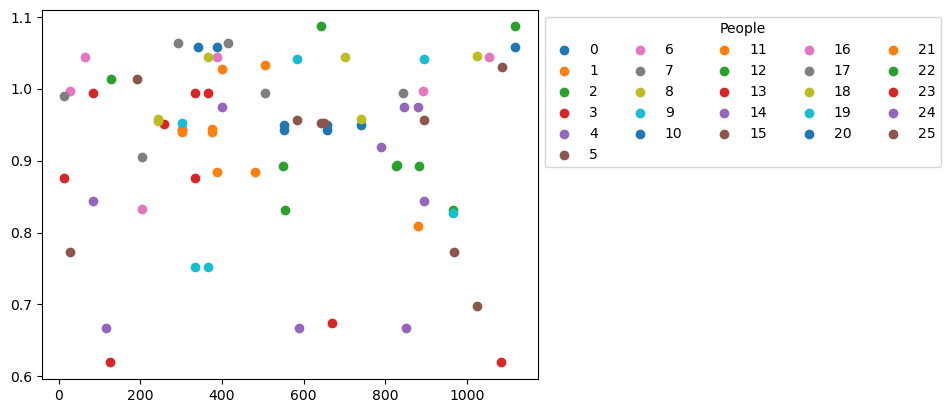

In [26]:
fig, ax = plt.subplots()

for count, (data, idx) in enumerate(zip(dataSet, series)):
    ax.scatter(idx, data, label = count)
EntVals = []
for k,v in best.items():
    EntVals.append(Entropy[k,v])
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)
plt.show()

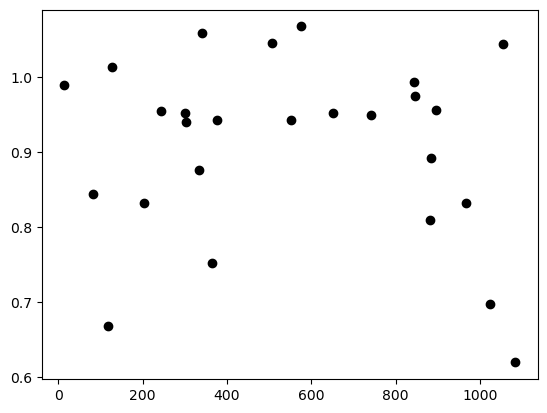

In [27]:
plt.scatter(best.values(), EntVals, c='black')
plt.show()

# Test

In [28]:
percents = [x/10 for x in range(0, 11, 2)]
TestSizes = []
ScheduleSet = [Grid(HOUR_PARTITIONS) for x in percents]
print(len(percents))
for perc in percents:
    Person.reset()
    TestSizes.append([Person() for x in range(fillGrid(perc))])

print("Set Loaded")
ct = 1
for timeSet, people in zip(ScheduleSet, TestSizes):
    
    for person in people:
        r_size = np.random.randint(timeSet.Grid.shape[1], dtype = np.uint64)
        #print(person.id)
        timeSet.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
    print("Filled Set: ", ct)
    ct += 1   

6
Set Loaded
Filled Set:  1
Filled Set:  2
Filled Set:  3
Filled Set:  4
Filled Set:  5
Filled Set:  6


In [23]:
for timeSet in ScheduleSet:
    print(timeSet.Grid.shape)

(0, 1152)
(230, 1152)
(460, 1152)
(691, 1152)
(921, 1152)
(1152, 1152)


In [ ]:
for timeSet, People in zip(ScheduleSet, TestSizes):
    b1, i, d, c = getBestSpot(People, timeSet)
    print(b1)
    b2, i ,d, c = getBestSpot2(People, timeSet)
    print(b2)


Alg1:,  492 / 691
Alg1:,  492 / 691


In [29]:
import timeit
g = []
g2 = []
ct = 1
for timeSet, People in zip(ScheduleSet, TestSizes):
    t = timeit.Timer(lambda: getBestSpot(People, timeSet))
    t2 = timeit.Timer(lambda: getBestSpot2(People, timeSet))
    
    g.append(t.repeat(number = 10))
    
    print("Next")
    
    g2.append(t2.repeat(number = 10))
    
    print("Done at, ", ct)
    ct += 1

Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152


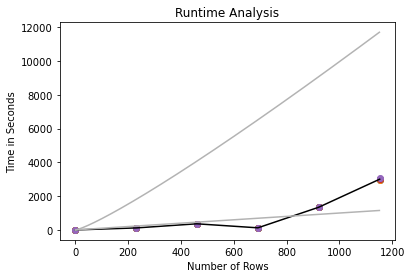

In [38]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()

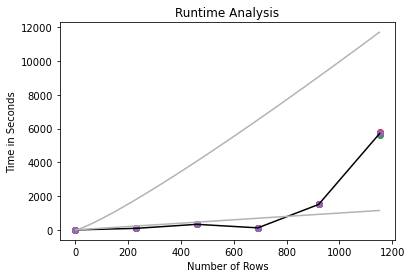

In [41]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g2)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()